In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

# init

In [2]:
# Re-reading the various datasets 
COLUMNS=['Peptide', 'HLA', 'agg_label', 'total_count', 'percentage_pos']

df_cedar_posneg_hp = pd.read_csv('../data/cedar_posneg_hp.csv')
df_cedar_subsampled_negs = pd.read_csv('../data/cedar_subsampled_negs.csv')
df_all = pd.read_csv('../data/cedar_filtered.csv', usecols = COLUMNS)#.drop(columns=['Unnamed: 0'])
df_all['len'] = df_all.Peptide.apply(len)

df_refined = pd.concat([df_all.query('agg_label==1'), df_all.query('agg_label==0 and total_count > 1')])
df_hp_hobohm = pd.concat([df_all.query('agg_label==1'), 
                          pd.read_csv('../data/human_proteome_negs_n5_hobohm1_rs13', usecols=COLUMNS[:2])])
df_hp_hobohm['agg_label'].fillna(0, inplace=True)
df_hp_hobohm['total_count'].fillna(1, inplace=True)
df_hp_hobohm['percentage_pos'].fillna(0, inplace=True)
df_hp_hobohm['len']=df_hp_hobohm['Peptide'].apply(len)

In [3]:
# Re-reading the core alignment data from the NNalign outputs
DATADIR = '../data/'
NNDIR='../../../nnalign/output/'
cores=[os.path.join(os.path.join(NNDIR,x),z) for x in os.listdir(NNDIR) \
       for z in os.listdir(os.path.join(NNDIR,x)) if z.endswith('pred')]

core_cedar_posneg_hp = pd.read_csv('../../../nnalign/output/cedar_posneg_hp.pep_30041\\cedar_posneg_hp.pep_30041.lg6.sorted.pred', sep='\t')
core_cedar_subsampled_negs = pd.read_csv('../../../nnalign/output/cedar_subsampled_negs.pep_24820\\cedar_subsampled_negs.pep_24820.lg6.sorted.pred', 
                                         sep='\t')
core_cedar_all = pd.read_csv('../../../nnalign/output/dataset_all.pep_31000\\dataset_all.pep_31000.lg6.sorted.pred',
                             sep='\t')
core_cedar_refined = pd.read_csv('../../../nnalign/output/dataset_filtered.pep_32896\\dataset_filtered.pep_32896.lg6.sorted.pred'
                                 , sep='\t')
core_cedar_hp_hobohm = pd.read_csv('../../../nnalign/output/dataset_hp_hobohm.pep_34725\\dataset_hp_hobohm.pep_34725.lg6.sorted.pred'
                                   , sep='\t')

In [4]:
# making a nice dict to house all my results
results = {}
keys=['cedar_subsampled_negs', 'cedar', 'cedar_refined', 'cedar_posneg_hp', 'cedar_hp_hobohm']
for key, df, core in zip(keys,
                         [df_cedar_subsampled_negs, df_all, df_refined, df_cedar_posneg_hp, df_hp_hobohm],
                         [core_cedar_subsampled_negs, core_cedar_all, core_cedar_refined, core_cedar_posneg_hp, core_cedar_hp_hobohm]):
    results[key] = {}
    core = pd.merge(df[['Peptide', 'HLA']], core, left_on='Peptide', right_on='Peptide')
    results[key]['df'] = df
    results[key]['core'] = core
    # quickly checking the datalength match
    print(key, len(df), len(core))

cedar_subsampled_negs 777 777
cedar 1687 1687
cedar_refined 777 777
cedar_posneg_hp 3738 3738
cedar_hp_hobohm 5173 5173


# AUCs etc

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

## Dataset comparison

cedar_subsampled_negs
AUC:	0.54233
cedar
AUC:	0.61617
cedar_refined
AUC:	0.65354
cedar_posneg_hp
AUC:	0.6878
cedar_hp_hobohm
AUC:	0.78062


Text(0.5, 1.0, 'Dataset comparison for NNAlign prediction')

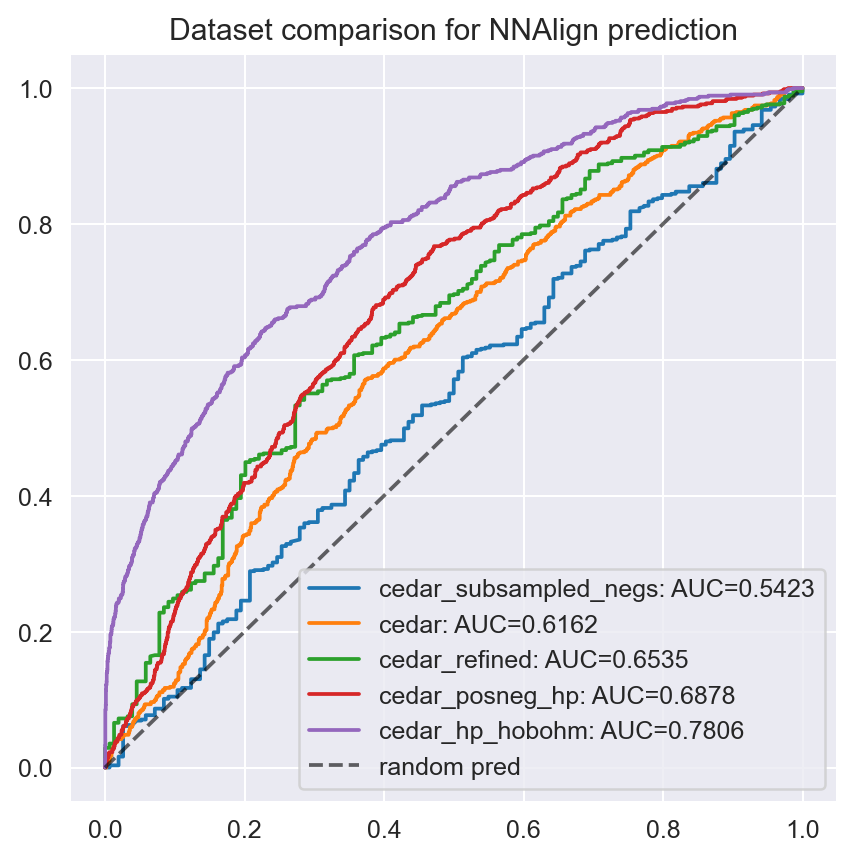

In [8]:
f,a = plt.subplots(1,1, figsize=(5.5,5.5))
for k in results.keys():
    y_true = results[k]['core']['Measure'].values.astype(int)
    y_score = results[k]['core']['Prediction'].values
    fpr,tpr,thresholds=roc_curve(y_true, y_score, pos_label=1.0)
    results[k]['fpr'] = fpr
    results[k]['tpr'] = tpr
    results[k]['auc'] = roc_auc_score(y_true, y_score)
    print(f'{k}\nAUC:\t{results[k]["auc"].round(5)}')
    sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={results[k]["auc"].round(4)}', estimator=None)
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6)
a.set_title('Dataset comparison for NNAlign prediction')

In [9]:
for k in results.keys():
    results[k]['core']['HLA'] = results[k]['core']['HLA'].apply(lambda x: x.replace('*',''))
    results[k]['core']['Measure'] = results[k]['core']['Measure'].astype(int)

## HLA comparison & using rank as scores

In [10]:
# Getting the best predicted HLA allele for the cedar dataset (used later for filtering in AUC vs HLA part)
from src.utils import flatten_level_columns, parse_netmhcpan_header, read_netmhcpan_results, query_melt_threshold, set_hla, return_columns, filter_rank, get_filtered_df
cedar_xls = read_netmhcpan_results('../data/cedar_filtered.xls')
cedar_xls = get_filtered_df(filter_rank(cedar_xls, 'EL_Rank'), cedar_xls)
cedar_all = pd.merge(left=df_all, right=cedar_xls.rename(columns={'HLA':'pred_HLA'}), left_index=True, right_index=True)
cedar_all['HLA']= cedar_all['HLA'].str.replace('*','')

In [12]:
# re-getting the predicted HLA and rank values for the negative part of results['cedar_hp_hobohm']
scored9=pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored10=pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored= pd.concat([scored9, scored10])
hp_neg = results[k]['core'].query('Measure==0')
hp_neg_scored = hp_neg.merge(scored.drop(columns=['HLA']),
                             left_on = 'Peptide', right_on = 'Peptide')
del scored, scored9, scored10, hp_neg

# Next up I need to basically merge the hp_neg_scored, cedar_all (which is basically cedar_scored with the predicted & true HLA)
# and the core (results['cedar_hp_hobohm']['core']) so I can filter on the results.

hp_neg_scored.columns = hp_neg_scored.columns.str.replace('-','_').str.replace('Rank','rank')
hp_neg_scored['agg_label']=0
hp_neg_scored['percentage_pos']=0
hp_neg_scored['total_count']=1
hp_neg_scored['len']=hp_neg_scored['Peptide'].apply(len)
hp_neg_scored['pred_HLA']=hp_neg_scored['HLA']

df_cedar_hp_scored = pd.concat([cedar_all.query('agg_label==1'), hp_neg_scored[cedar_all.columns]])
df_cedar_hp_scored

cedar_hp_core = results[k]['core'].merge(df_cedar_hp_scored.drop(columns=['HLA', 'len']).rename(columns={'core':'netMHC_core'}),
                         left_on = 'Peptide', right_on = 'Peptide')


## Scores comparison

3294
1879
5173


Text(0.5, 0.98, 'Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')

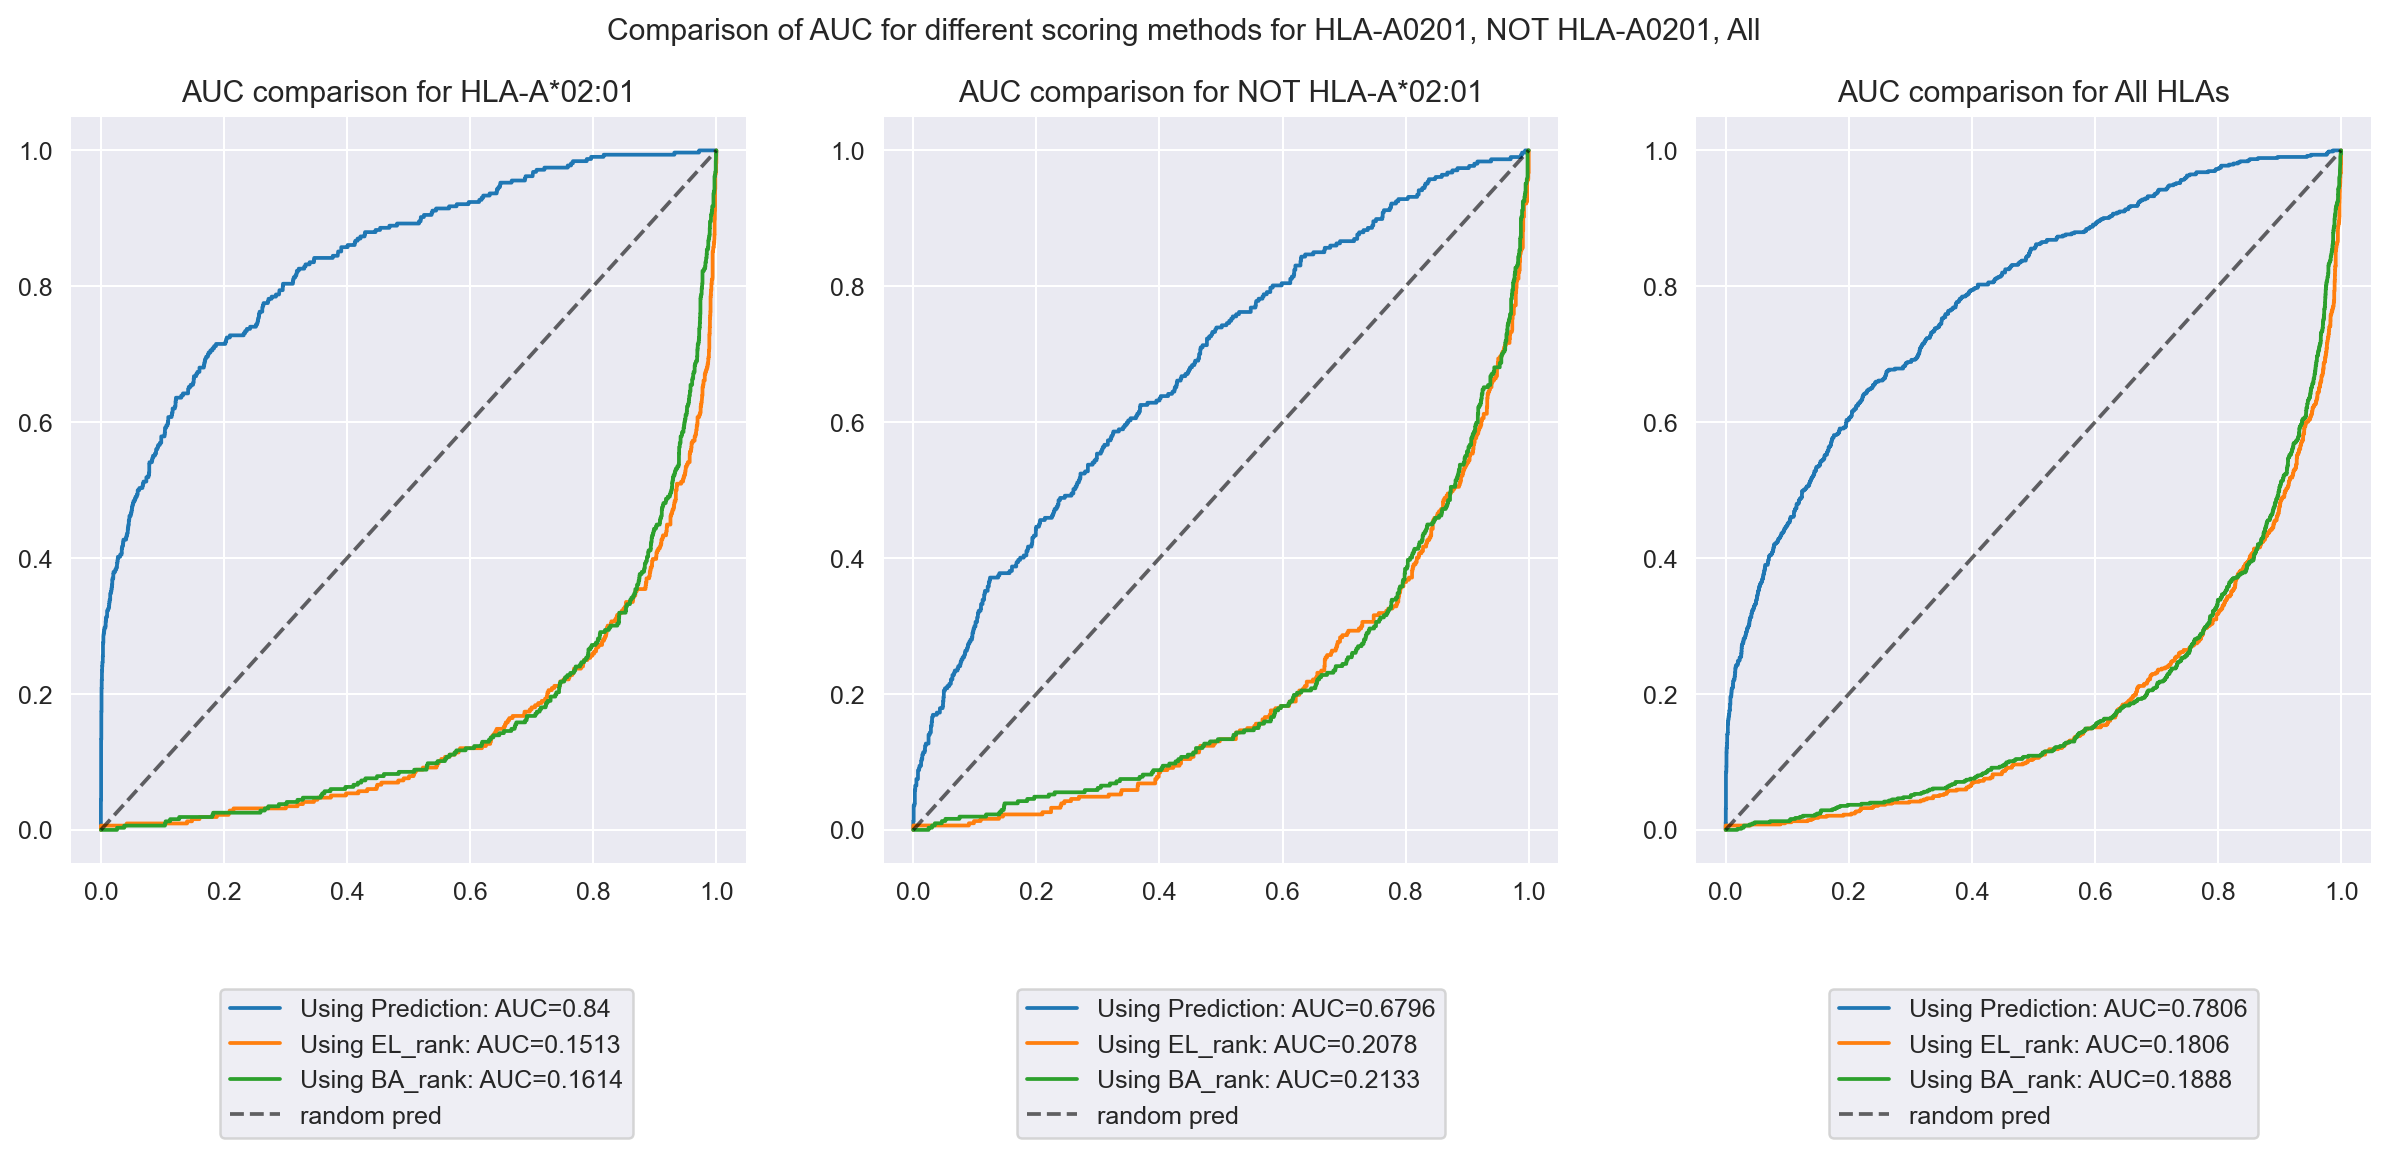

In [13]:
f,a = plt.subplots(1,3, figsize=(16.5, 5.5))

for top_hla, axis in zip(['a0201', 'no', 'all'], [0,1,2]):
    if top_hla=='a0201':
        tmp = cedar_hp_core.query('HLA=="HLA-A02:01"').copy()
        name = "HLA-A*02:01" 
    if top_hla=='no':
        tmp = cedar_hp_core.query('HLA!="HLA-A02:01"').copy()
        name = "NOT HLA-A*02:01"
    if top_hla=='all':
        tmp = cedar_hp_core.copy()
        name = "All HLAs"
    print(len(tmp))
    for scoring in ['Prediction', 'EL_rank', 'BA_rank']:
        y_true = tmp['agg_label'].values
        scores = tmp[scoring].values
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
                
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].set_title(f'AUC comparison for {name}')
    a[axis].legend(bbox_to_anchor=(.85, -.15))
f.suptitle('Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')


## True HLA vs False

3294
1879
5173


Text(0.5, 0.98, 'Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')

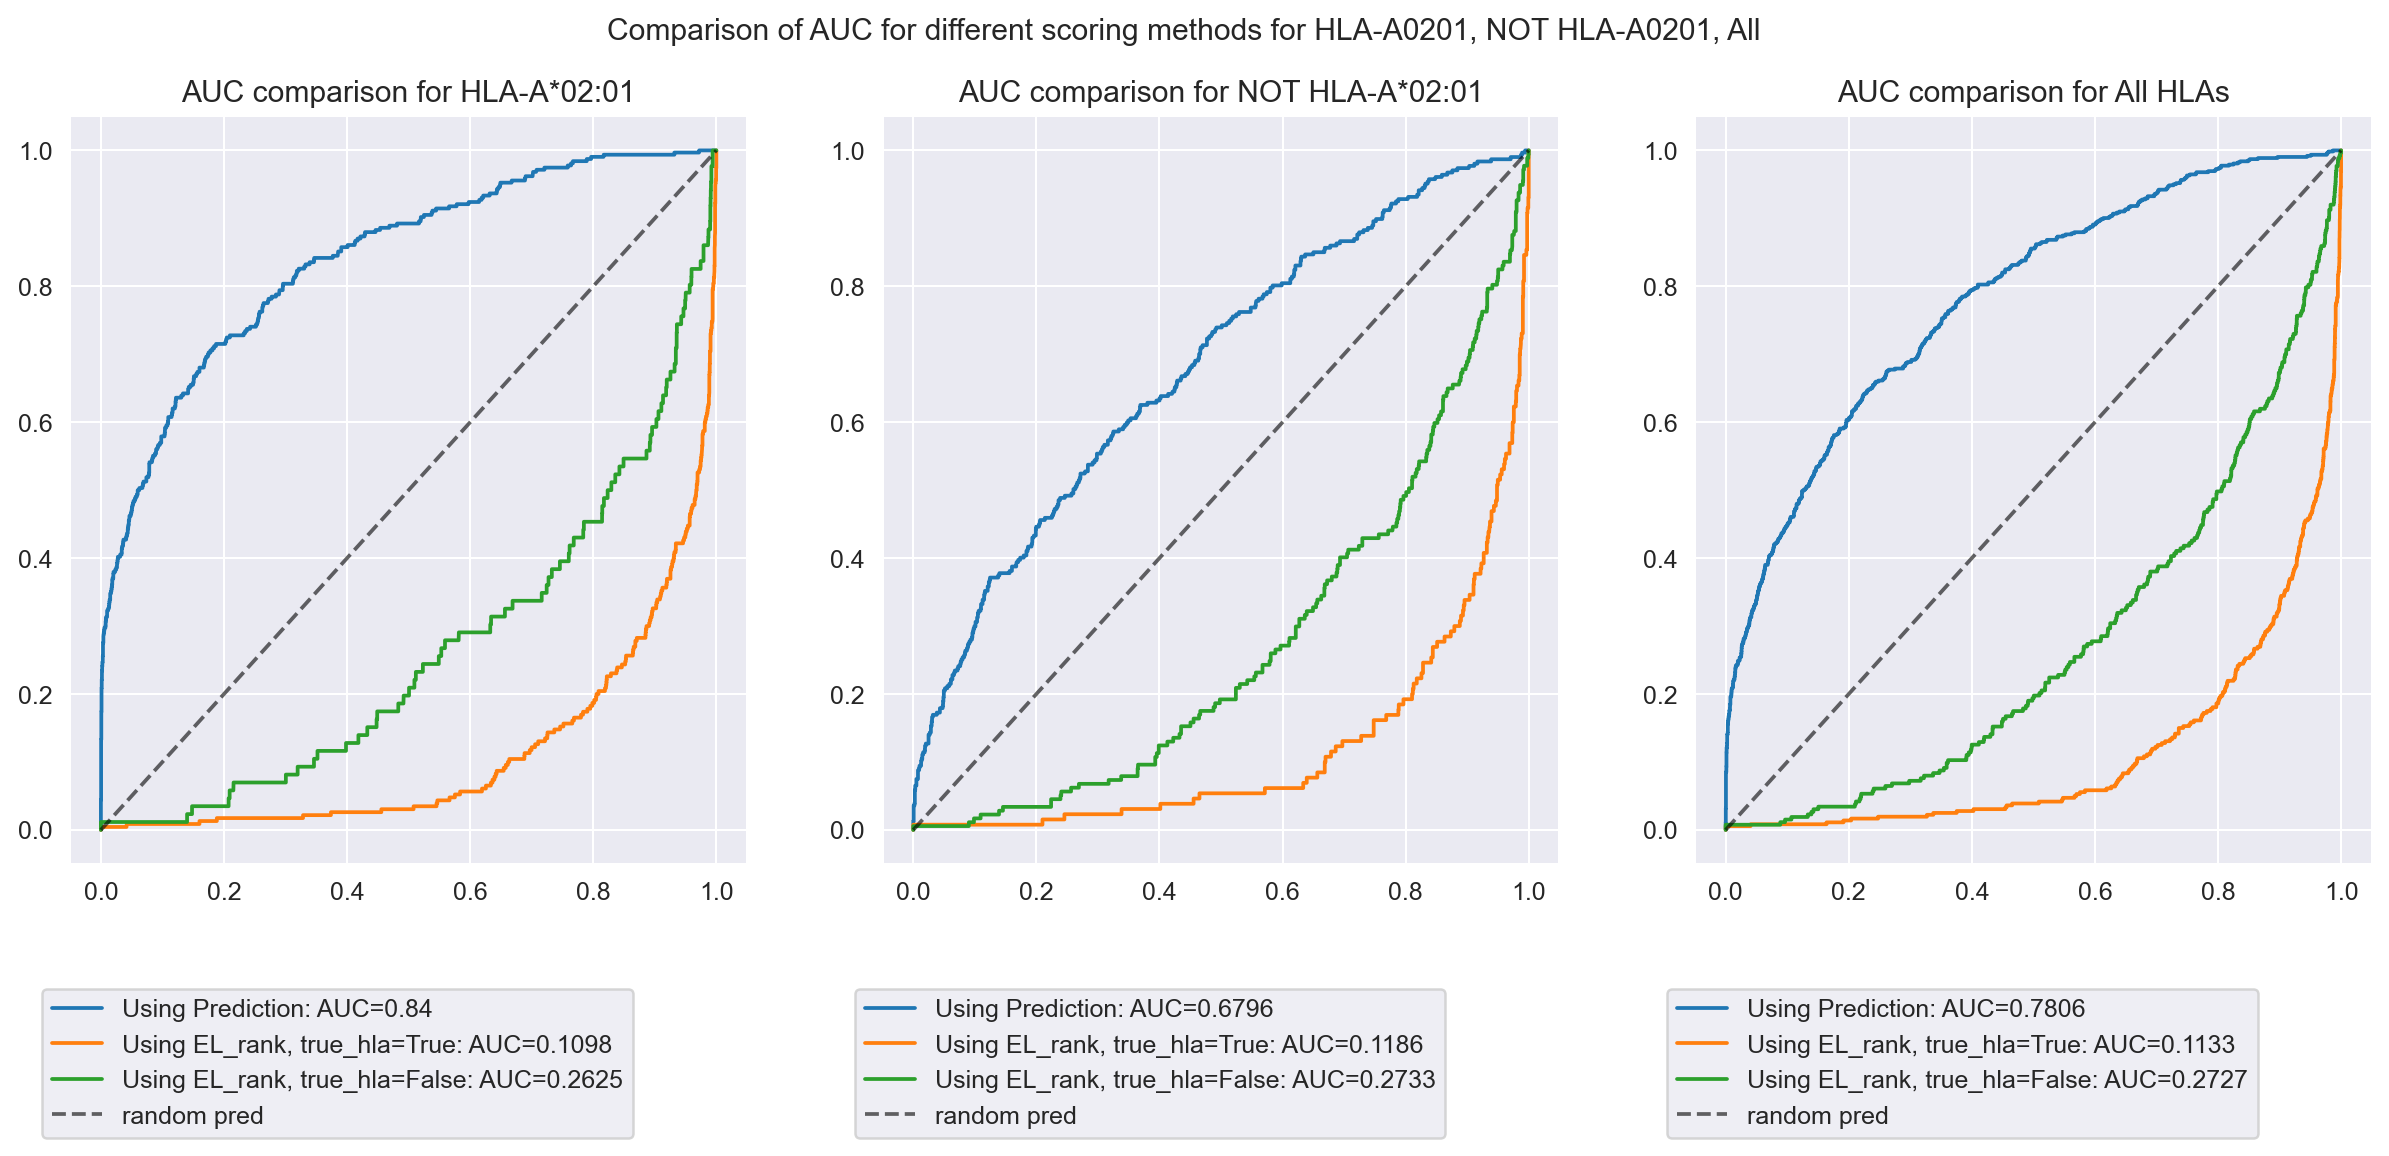

In [14]:
f,a = plt.subplots(1,3, figsize=(16.5, 5.5))

for top_hla, axis in zip(['a0201', 'no', 'all'], [0,1,2]):
    if top_hla=='a0201':
        tmp = cedar_hp_core.query('HLA=="HLA-A02:01"').copy()
        name = "HLA-A*02:01" 
    if top_hla=='no':
        tmp = cedar_hp_core.query('HLA!="HLA-A02:01"').copy()
        name = "NOT HLA-A*02:01"
    if top_hla=='all':
        tmp = cedar_hp_core.copy()
        name = "All HLAs"
    print(len(tmp))
    for scoring in ['Prediction', 'EL_rank']:
        if scoring == 'Prediction':
            y_true = tmp['agg_label'].values
            scores = tmp[scoring].values
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        else:
            negs = tmp.query('agg_label==0')
            for true_hla in [True, False]:
                pos = tmp.query('agg_label==1')
                pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
                tmp_1 = pd.concat([pos, negs])
                y_true = tmp_1['agg_label'].values
                scores = tmp_1[scoring].values
                fpr, tpr, _ = roc_curve(y_true, scores)
                auc = roc_auc_score(y_true, scores)
                sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}, true_hla={true_hla}: AUC={auc.round(4)}', ax = a[axis], estimator=None)
                
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].set_title(f'AUC comparison for {name}')
    a[axis].legend(bbox_to_anchor=(.85, -.15))
f.suptitle('Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')


## Top 5 HLAs comparison using EL_rank

<AxesSubplot:title={'center':'Predicted HLA is NOT true HLA'}>

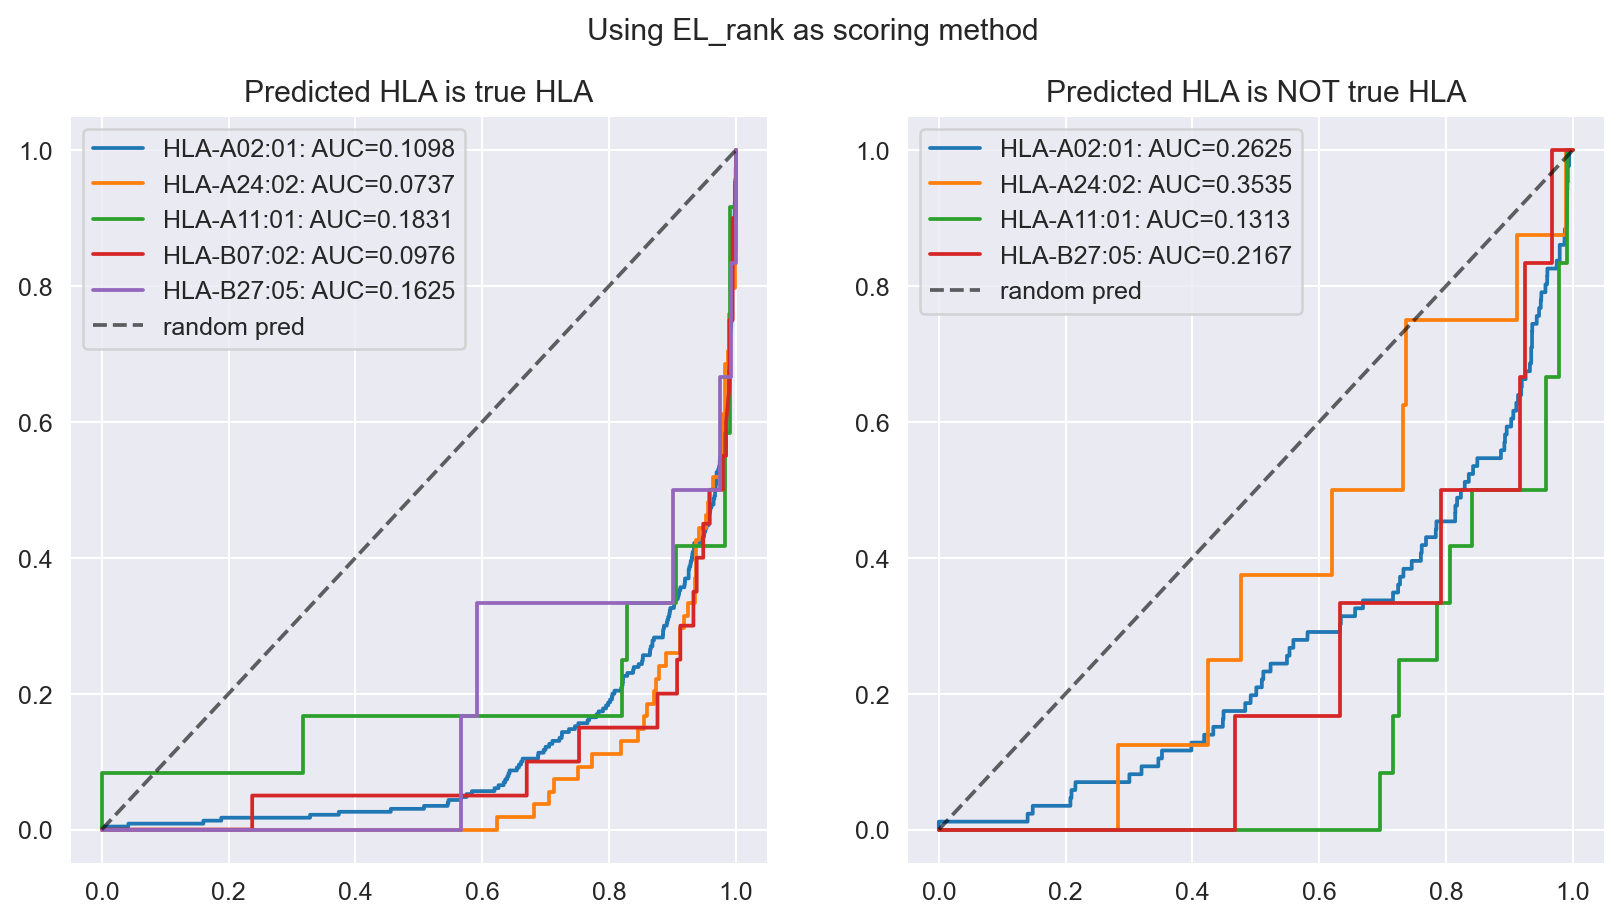

In [15]:
top10_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(10).index
top5_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(5).index

f,a = plt.subplots(1,2, figsize=(11, 5.5))

scoring='EL_rank'
for hla in top5_hla:
    tmp = cedar_hp_core.query('HLA==@hla')
    negs = tmp.query('agg_label==0')
    if len(negs)==0:
        continue
    for true_hla,axis in zip([True, False], [0,1]):
        pos = tmp.query('agg_label==1')
        pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
        if len(pos)==0:
            break
        tmp_1 = pd.concat([pos, negs])
        y_true = tmp_1['agg_label'].values
        scores = tmp_1[scoring].values
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'{hla}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        name = 'Predicted HLA is true HLA' if true_hla else 'Predicted HLA is NOT true HLA'
        a[axis].set_title(name)
f.suptitle('Using EL_rank as scoring method')
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[0])
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[1])

<AxesSubplot:title={'center':'Predicted HLA is NOT true HLA'}>

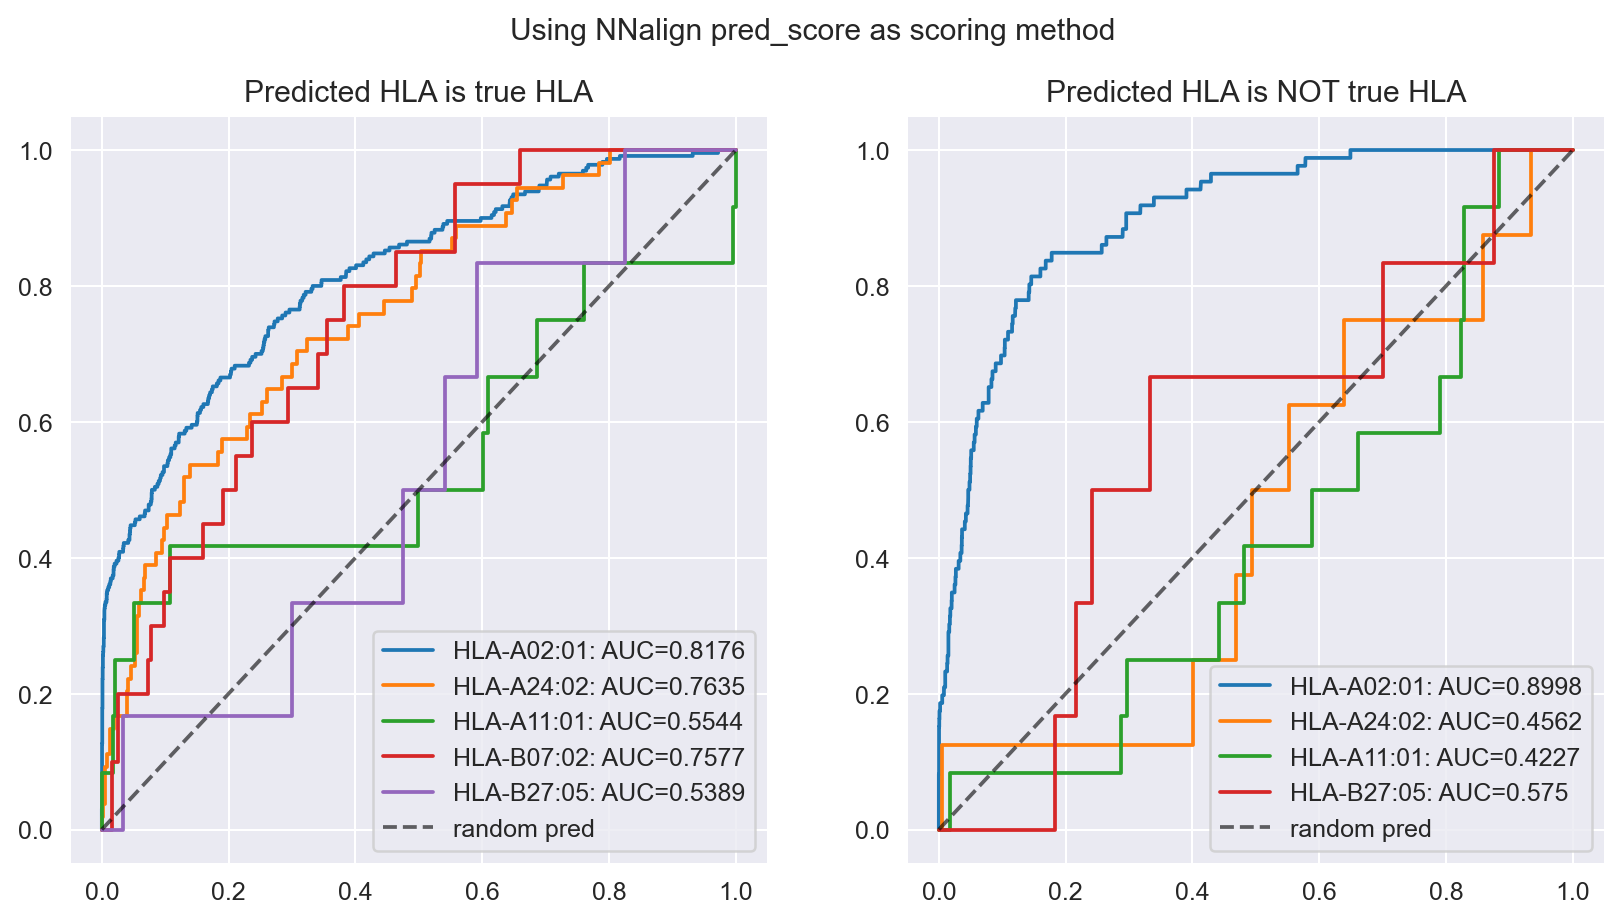

In [16]:
top10_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(10).index
top5_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(5).index

f,a = plt.subplots(1,2, figsize=(11, 5.5))

scoring='Prediction'
for hla in top5_hla:
    tmp = cedar_hp_core.query('HLA==@hla')
    negs = tmp.query('agg_label==0')
    if len(negs)==0:
        continue
    for true_hla,axis in zip([True, False], [0,1]):
        pos = tmp.query('agg_label==1')
        pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
        if len(pos)==0:
            break
        tmp_1 = pd.concat([pos, negs])
        y_true = tmp_1['agg_label'].values
        scores = tmp_1[scoring].values
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'{hla}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        name = 'Predicted HLA is true HLA' if true_hla else 'Predicted HLA is NOT true HLA'
        a[axis].set_title(name)
f.suptitle('Using NNalign pred_score as scoring method')
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[0])
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[1])

## Cedar ranks checks

In [17]:
print(f"Percentage of correctly predicted HLA: {(len(cedar_all.loc[cedar_all['HLA']==cedar_all['pred_HLA']])/len(cedar_all)):.3%}")

Percentage of correctly predicted HLA: 48.607%


Text(0.5, 1.0, 'CEDAR EL_rank distributions for Pos vs Neg')

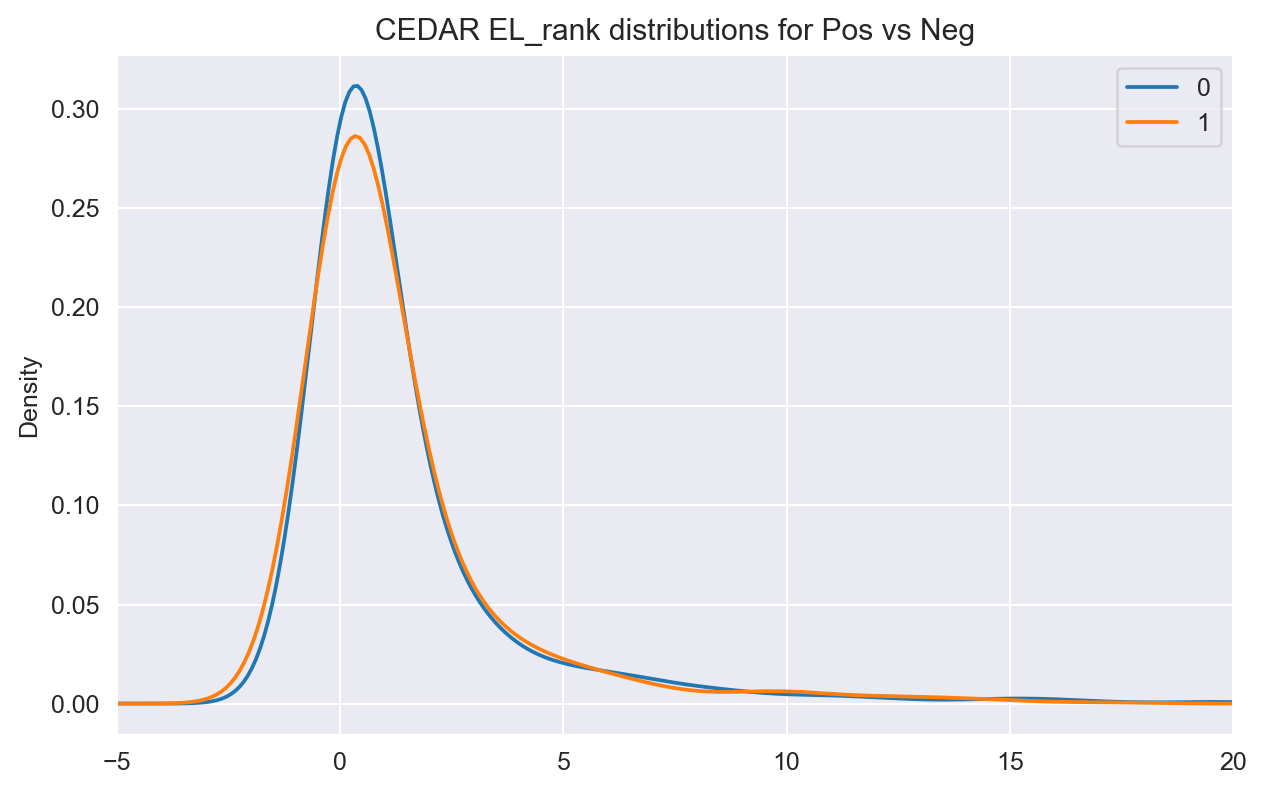

In [18]:
f,a=plt.subplots(figsize=(8,5))
cedar_all.groupby('agg_label')['EL_rank'].plot(kind='kde', legend=True)
a.set_xlim([-5,20])
a.set_title('CEDAR EL_rank distributions for Pos vs Neg')

# New Cedar datadump 

In [ ]:
qsub -W group_list=vaccine -A vaccine -l nodes=1:ppn=2,mem=12gb,walltime=1:00:00

## reloading new stuff

In [ ]:
'HLA-A02:06', 'HLA-B15:01', 'HLA-A02:01', 'HLA-A03:01',
       'HLA-A11:01', 'HLA-B07:02', 'HLA-A24:02', 'HLA-A01:01',
       'HLA-B35:01', 'HLA-B40:01', 'HLA-B08:01', 'HLA-B27:05'

In [125]:
pd.read_csv('../data/cedar_neoepitope_220701.csv')['Peptide'].to_csv('../data/cedar_neoepitope_220701.pep', index=False,header=None)
pd.read_csv('../data/cedar_neoepi_hpneg.csv')['Peptide'].to_csv('../data/cedar_neoepi_hpneg.pep', index=False,header=None)

In [20]:
df_cedar_neoepi = pd.read_csv('../data/cedar_neoepitope_220701.csv').query('len>=8 and len<=14').drop(columns = ['Unnamed: 0'])
prime_cedarneoepi = pd.read_csv('../../../gfeller_tools/PRIME/output/cedar_neoepi_220701_prime_out.txt',
                                sep='\t', comment='#')
nnalign_cedarneoepi = pd.read_csv('../../../nnalign/output/neo_epi_220701.pep_18784/neo_epi_220701.pep_18784.lg6.sorted.pred',
                                 sep='\t')

cedar_prime = pd.merge(df_cedar_neoepi, prime_cedarneoepi, left_on='Peptide', right_on='Peptide')

# neoepi_hp = new cedar pos + hp negs, no cedar negs
df_neoepi_hp = pd.read_csv('../data/cedar_neoepi_hpneg.csv')
prime_neoepi_hp = pd.read_csv('../../../gfeller_tools/PRIME/output/cedar_neoepi_hpneg.txt', 
                              sep='\t', comment='#')
nnalign_hpneoepi = pd.read_csv('../../../nnalign/output/cedar_neoepi_hpneg.pep_9121/cedar_neoepi_hpneg.pep_9121.lg6.sorted.pred',
                               sep='\t')



In [83]:
prime_neoepi_new = pd.merge(df_cedar_neoepi, prime_cedarneoepi, left_on='Peptide', right_on='Peptide')
prime_mixed_new = pd.merge(df_neoepi_hp, prime_neoepi_hp, left_on='Peptide', right_on='Peptide')

## Reloading old PRIME results

### old mixed (cedar pos + hp negs)

In [76]:
mixed = pd.read_csv('./cedar_pos_hpneg.txt', header=None).rename(columns={0:'Peptide'})
mixed['len'] = mixed['Peptide'].apply(len)
mixed_tmp = mixed.Peptide.unique()
negatives_from_hpnegs = pd.concat([pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/8mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/11mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])]).query('Peptide in @mixed_tmp')
negatives_from_hpnegs['agg_label']=0
pos_mixed = cedar_all.query('Peptide in @mixed_tmp')
negatives_from_hpnegs['pred_HLA'] = negatives_from_hpnegs['HLA']
negatives_from_hpnegs.columns = negatives_from_hpnegs.columns.str.replace('Rank','rank')
common_cols = negatives_from_hpnegs.columns.join(pos_mixed.columns,how='inner')


In [77]:
mixed = pd.concat([pos_mixed[common_cols], negatives_from_hpnegs[common_cols]],ignore_index=True)
mixed['len'] = mixed['Peptide'].apply(len)
mixed_prime = pd.read_csv('./cedar_pos_hpneg_results.txt', comment='#', sep = '\t')
prime_mixed_old = pd.merge(mixed, mixed_prime, left_on='Peptide', right_on='Peptide')
del mixed, mixed_prime
display(prime_mixed_old.head())

,Peptide,HLA,BA_rank,EL_rank,core,icore,agg_label,pred_HLA,len,%Rank_bestAllele,Score_bestAllele,%RankBinding_bestAllele,BestAllele,%Rank_A0201,Score_A0201,%RankBinding_A0201,%Rank_B0702,Score_B0702,%RankBinding_B0702,%Rank_B2705,Score_B2705,%RankBinding_B2705,%Rank_A2402,Score_A2402,%RankBinding_A2402,%Rank_A0206,Score_A0206,%RankBinding_A0206,%Rank_B3501,Score_B3501,%RankBinding_B3501,%Rank_A1101,Score_A1101,%RankBinding_A1101,%Rank_B1501,Score_B1501,%RankBinding_B1501,%Rank_A0301,Score_A0301,%RankBinding_A0301,%Rank_A0101,Score_A0101,%RankBinding_A0101,%Rank_B4001,Score_B4001,%RankBinding_B4001,%Rank_C0602,Score_C0602,%RankBinding_C0602,%Rank_C0501,Score_C0501,%RankBinding_C0501,%Rank_C1502,Score_C1502,%RankBinding_C1502,%Rank_A2902,Score_A2902,%RankBinding_A2902,%Rank_A1102,Score_A1102,%RankBinding_A1102,%Rank_B4403,Score_B4403,%RankBinding_B4403,%Rank_B3801,Score_B3801,%RankBinding_B3801,%Rank_A0203,Score_A0203,%RankBinding_A0203,%Rank_B5701,Score_B5701,%RankBinding_B5701
0,AAGIGILTV,HLA-A02:01,5.0999,1.2552,AAGIGILTV,AAGIGILTV,1,HLA-A02:06,9,0.132,0.171975,0.183,C1502,0.561,0.060660,1.532,1.026,0.026231,5.844,1.464,0.026663,5.738,3.009,0.015688,10.241,1.827,0.026896,2.479,0.534,0.060078,2.120,0.688,0.042942,3.282,1.695,0.022995,6.764,3.324,0.010799,15.265,2.891,0.013011,12.510,2.372,0.014680,10.995,0.642,0.078056,1.038,0.229,0.095402,1.041,0.132,0.171975,0.183,4.336,0.011712,10.141,1.886,0.021720,7.202,1.841,0.019363,8.162,1.859,0.024661,6.260,1.175,0.040600,1.532,3.101,0.013437,12.087
1,AAGIGILTV,HLA-A02:06,5.0999,1.2552,AAGIGILTV,AAGIGILTV,0,HLA-A02:06,9,0.132,0.171975,0.183,C1502,0.561,0.060660,1.532,1.026,0.026231,5.844,1.464,0.026663,5.738,3.009,0.015688,10.241,1.827,0.026896,2.479,0.534,0.060078,2.120,0.688,0.042942,3.282,1.695,0.022995,6.764,3.324,0.010799,15.265,2.891,0.013011,12.510,2.372,0.014680,10.995,0.642,0.078056,1.038,0.229,0.095402,1.041,0.132,0.171975,0.183,4.336,0.011712,10.141,1.886,0.021720,7.202,1.841,0.019363,8.162,1.859,0.024661,6.260,1.175,0.040600,1.532,3.101,0.013437,12.087
2,AEHSLQVAY,HLA-B44:03,1.5529,0.2435,AEHSLQVAY,AEHSLQVAY,1,HLA-B15:01,9,0.033,0.172182,0.031,B4403,13.205,0.003425,9.760,19.849,0.001882,15.997,1.254,0.029885,0.933,17.222,0.002446,12.164,15.965,0.003371,27.496,0.927,0.040218,0.643,7.467,0.005487,5.444,0.098,0.133342,0.071,3.245,0.011021,2.742,1.929,0.018483,1.606,0.238,0.068823,0.290,8.415,0.006219,3.216,20.493,0.001657,18.334,20.336,0.001922,10.497,0.450,0.082695,0.141,10.391,0.004117,7.214,0.033,0.172182,0.031,5.942,0.008073,3.733,9.895,0.005558,15.924,6.539,0.006650,4.513
3,AILALLPAL,HLA-A02:01,0.1296,0.1473,AILALLPAL,AILALLPAL,1,HLA-A02:06,9,0.066,0.174964,0.082,A0201,0.066,0.174964,0.082,0.567,0.039473,1.241,1.949,0.020720,2.626,2.716,0.017513,3.143,0.122,0.134277,0.119,1.652,0.025435,2.095,2.045,0.018403,2.982,1.751,0.022277,2.427,6.957,0.005355,10.402,19.258,0.001885,31.115,1.897,0.017662,3.115,3.734,0.016114,4.918,3.343,0.012032,4.630,0.919,0.058494,1.084,2.724,0.019109,4.096,1.708,0.023934,2.242,5.154,0.007897,7.060,2.755,0.017084,3.226,0.790,0.053497,0.718,3.338,0.012629,4.408
4,AILALLPAL,HLA-A02:06,0.1296,0.1473,AILALLPAL,AILALLPAL,0,HLA-A02:06,9,0.066,0.174964,0.082,A0201,0.066,0.174964,0.082,0.567,0.039473,1.241,1.949,0.020720,2.626,2.716,0.017513,3.143,0.122,0.134277,0.119,1.652,0.025435,2.095,2.045,0.018403,2.982,1.751,0.022277,2.427,6.957,0.005355,10.402,19.258,0.001885,31.115,1.897,0.017662,3.115,3.734,0.016114,4.918,3.343,0.012032,4.630,0.919,0.058494,1.084,2.724,0.019109,4.096,1.708,0.023934,2.242,5.154,0.007897,7.060,2.755,0.017084,3.226,0.790,0.053497,0.718,3.338,0.012629,4.408


### old all (cedar only, selecting ELIS and collapsing duplicates, no refined filtering on negs)

In [78]:
prime_cedar_old = pd.merge(cedar_all, pd.read_csv('./PRIME_cedar_filtered_results.txt', comment = '#', sep = '\t'), 
                       left_on = 'Peptide', right_on = 'Peptide')

## PRIME comparison 

In [108]:
del prime_cedarneoepi, prime_neoepi_hp
prime_cedar_old['kind'] = 'cedar_old'
prime_neoepi_new['kind'] = 'neoepi_new'
prime_mixed_old['kind'] = 'mixed_old'
prime_mixed_new['kind'] = 'mixed_new'
cols_merged = prime_cedar_old.columns.join(prime_neoepi_new.columns, how='inner').join(prime_mixed_old.columns, how='inner').join(prime_mixed_new.columns, how='inner')
cols_merged

Index(['Peptide', 'HLA', 'agg_label', 'len', '%Rank_bestAllele',
       'Score_bestAllele', '%RankBinding_bestAllele', 'BestAllele',
       '%Rank_A0201', 'Score_A0201', '%RankBinding_A0201', '%Rank_A2402',
       'Score_A2402', '%RankBinding_A2402', '%Rank_A0301', 'Score_A0301',
       '%RankBinding_A0301', '%Rank_B2705', 'Score_B2705',
       '%RankBinding_B2705', '%Rank_A1101', 'Score_A1101',
       '%RankBinding_A1101', '%Rank_A0101', 'Score_A0101',
       '%RankBinding_A0101', '%Rank_B0702', 'Score_B0702',
       '%RankBinding_B0702', '%Rank_B3501', 'Score_B3501',
       '%RankBinding_B3501', '%Rank_B1501', 'Score_B1501',
       '%RankBinding_B1501', 'kind'],
      dtype='object')

In [107]:
prime_results = {'cedar_old':prime_cedar_old,
                 'neoepi_new':prime_neoepi_new,
                 'mixed_old':prime_mixed_old,
                 'mixed_new':prime_mixed_new}

for k,v in prime_results.items():
    

IndentationError: expected an indented block (3214594726.py, line 7)